In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

In [2]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE=20000
EMBEDDING_DIM=100
EPOCHS=10
BATCH_SIZE=512

In [3]:
print("[] Info: Loading Word2Vecs ... ")
word2vec = {}

glove_file = open('glove6d/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    word2vec[word] = vector_dimensions
glove_file.close()

[] Info: Loading Word2Vecs ... 


In [4]:
train = pd.read_csv('toxic_data/train.csv')
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
possible_labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
target = train[possible_labels].values

In [5]:
print(f"Max length of Sequence is : {max(len(s) for s in sentences)}")
print(f"Min length of Sequence is : {min(len(s) for s in sentences)}")
s = sorted(len(s) for s in sentences)
print(f"Median length of Sequence is : {s[len(s) // 2]}")

Max length of Sequence is : 5000
Min length of Sequence is : 6
Median length of Sequence is : 205


In [6]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [7]:
word2idx = tokenizer.word_index
print(f"Length of Unique words are {len(word2idx)}")

Length of Unique words are 210337


In [8]:
data = pad_sequences(sequences,maxlen= MAX_SEQUENCE_LENGTH)
print(data.shape)

(159571, 100)


In [9]:
num_words = min(MAX_VOCAB_SIZE,len(word2idx)+1)

In [10]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, index in word2idx.items():
    if index < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [11]:
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights = [embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False)

In [12]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128,3,activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128,activation='relu')(x)
output = Dense(len(possible_labels),activation='sigmoid')(x)

model = Model(input_, output)
model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 128)            49280 

In [13]:
r = model.fit(data, target, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 17s 31ms/step - loss: 0.1007 - accuracy: 0.9639 - val_loss: 0.0764 - val_accuracy: 0.9941
Epoch 2/10
250/250 [==============================] - 7s 28ms/step - loss: 0.0735 - accuracy: 0.9935 - val_loss: 0.0717 - val_accuracy: 0.9941
Epoch 3/10
250/250 [==============================] - 7s 28ms/step - loss: 0.0677 - accuracy: 0.9934 - val_loss: 0.0953 - val_accuracy: 0.9941
Epoch 4/10
250/250 [==============================] - 8s 30ms/step - loss: 0.0637 - accuracy: 0.9928 - val_loss: 0.0674 - val_accuracy: 0.9940
Epoch 5/10
250/250 [==============================] - 7s 30ms/step - loss: 0.0603 - accuracy: 0.9928 - val_loss: 0.0674 - val_accuracy: 0.9940
Epoch 6/10
250/250 [==============================] - 7s 28ms/step - loss: 0.0573 - accuracy: 0.9928 - val_loss: 0.0758 - val_accuracy: 0.9872
Epoch 7/10
250/250 [==============================] - 7s 27ms/step - loss: 0.0543 - accuracy: 0.9920 - val_loss: 0.0698 - val_accuracy: 0.958

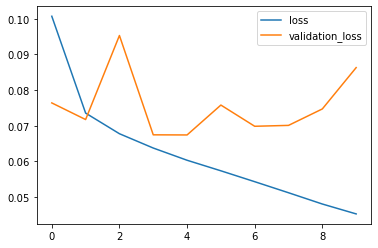

In [14]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.show()

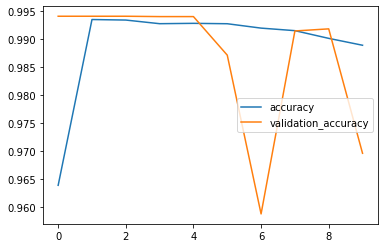

In [15]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.show()

In [20]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(target[:,j], p[:,j])
    aucs.append(auc)

In [21]:
print(np.mean(aucs))

0.9791531168906333


In [22]:
print(aucs)

[0.9700489608399613, 0.9873244783184398, 0.9831871120411793, 0.9770178698930525, 0.9795928300858523, 0.9777474501653135]
